In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data.csv')

df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df = df[df.index >= '2021-04-01']

target_col = 'SPY_vol_5d' 
# target_col = ['SPY_log_return']

series = df[target_col].dropna()



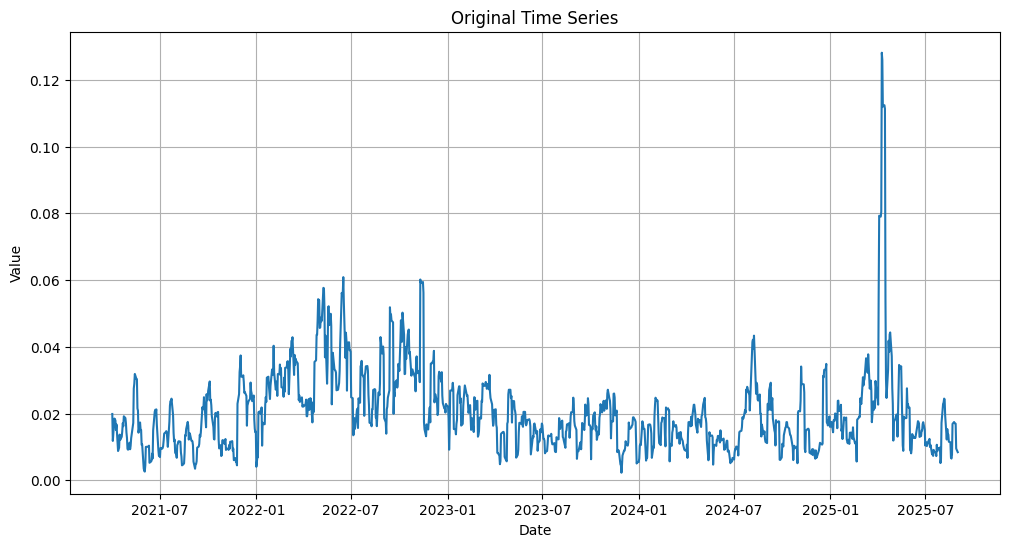

==STATIONARITY ANALYSIS==
Original series:
ADF Statistic: -3.602170
p-value: 0.005720
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary: True
--------------------------------------------------
Recommended d = 0


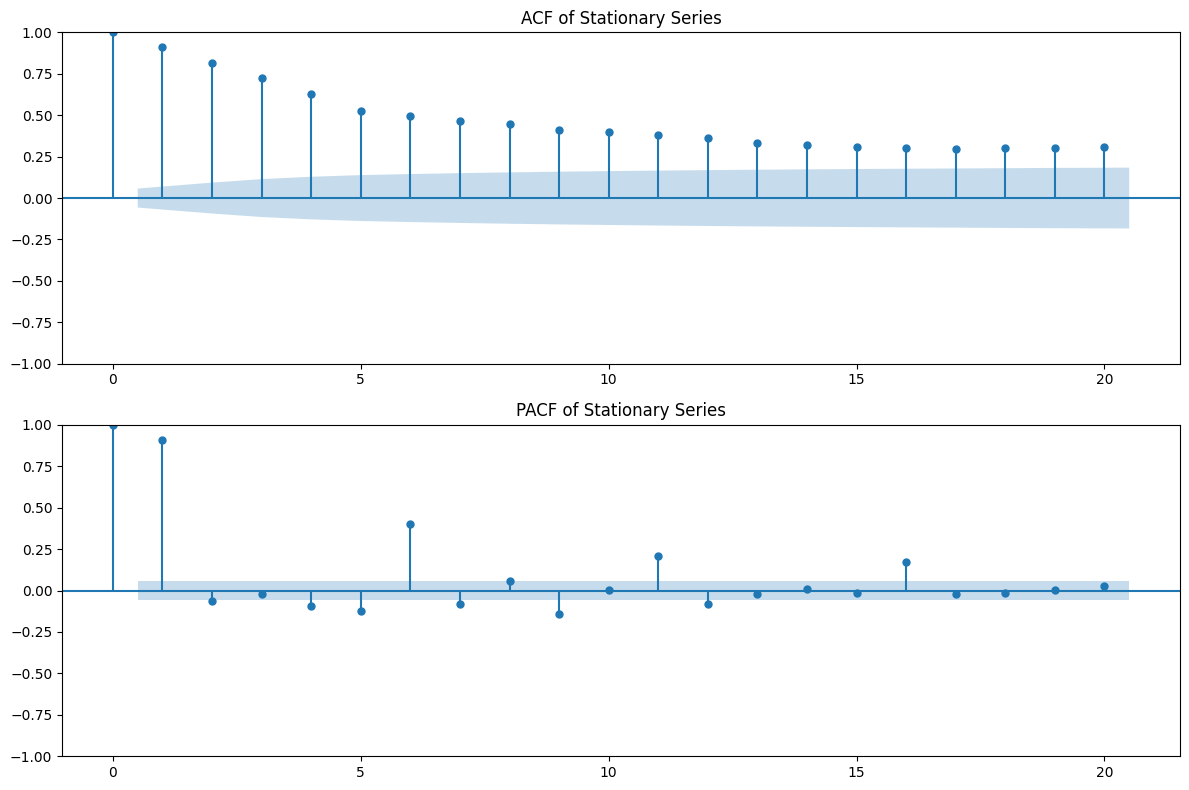

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')


# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(series.index, series.values)
plt.title('Original Time Series')
plt.ylabel('Value')
plt.xlabel('Date')
plt.grid(True)
plt.show()

def check_stationarity(timeseries):
    """Check stationarity using ADF test"""
    result = adfuller(timeseries.dropna())
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    
    is_stationary = result[1] <= 0.05
    print(f"Stationary: {is_stationary}")
    print("-" * 50)
    return is_stationary

print("==STATIONARITY ANALYSIS==")
print("Original series:")
is_stationary_original = check_stationarity(series)

d = 0
current_data = series.copy()

if not is_stationary_original:
    # Try first difference
    d = 1
    diff_1 = series.diff().dropna()
    print("First difference:")
    is_stationary_diff1 = check_stationarity(diff_1)
    
    if not is_stationary_diff1:
        # Try second difference
        d = 2
        diff_2 = diff_1.diff().dropna()
        print("Second difference:")
        is_stationary_diff2 = check_stationarity(diff_2)
    else:
        diff_2 = None
else:
    diff_1 = None
    diff_2 = None

print(f"Recommended d = {d}")

stationary_data = current_data

# acf/pacf analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(stationary_data, ax=ax1, lags=20, title='ACF of Stationary Series')
plot_pacf(stationary_data, ax=ax2, lags=20, method='ywm', title='PACF of Stationary Series')
plt.tight_layout()
plt.show()

In [3]:
def run_arima_forecast(data, target_col, test_size=0.2, order=(1,0,0)):
    """
    Run ARIMA model and compare forecasts with actual values
    """
    # Prepare data - ensure no NaN
    series = data[target_col].dropna()
    print(f"Clean data points: {len(series)}")
    
    # Split into train/test
    split_idx = int(len(series) * (1 - test_size))
    train = series.iloc[:split_idx]
    test = series.iloc[split_idx:]
    
    # print(f"\n=== DATA SPLIT ===")
    # print(f"Training: {train.index[0]} to {train.index[-1]} ({len(train)} points)")
    # print(f"Testing:  {test.index[0]} to {test.index[-1]} ({len(test)} points)")
    
    # Fit ARIMA model
    print(f"\n=== FITTING ARIMA{order} ===")
    model = ARIMA(train, order=order)
    fitted_model = model.fit()
    
    # Generate forecasts
    forecast_steps = len(test)
    forecast = fitted_model.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean
    confidence_int = forecast.conf_int()
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Actual': test.values,
        'Forecast': forecast_mean.values,
        'Lower_CI': confidence_int.iloc[:, 0].values,
        'Upper_CI': confidence_int.iloc[:, 1].values
    }, index=test.index)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Forecast']))
    mae = mean_absolute_error(results_df['Actual'], results_df['Forecast'])
    
    # Handle MAPE with zero values
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((results_df['Actual'] - results_df['Forecast']) / results_df['Actual'])) * 100
        mape = np.nan if np.isnan(mape) else mape
    
    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'AIC': fitted_model.aic,
        'BIC': fitted_model.bic
    }
    
    print(f"\n=== MODEL PERFORMANCE ===")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"MAPE: {mape:.2f}%" if not np.isnan(mape) else "MAPE: NaN (zero values)")
    print(f"AIC: {fitted_model.aic:.2f}")
    print(f"BIC: {fitted_model.bic:.2f}")
    
    return fitted_model, results_df, metrics, train, test

# Run the ARIMA model
model, results, metrics, train_data, test_data = run_arima_forecast(
    data=df, 
    target_col=target_col, 
    order=(1,0,0)
)

Clean data points: 1168

=== FITTING ARIMA(1, 0, 0) ===

=== MODEL PERFORMANCE ===
RMSE: 0.018297
MAE: 0.010337
MAPE: 60.17%
AIC: -7383.20
BIC: -7368.69


In [4]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:             SPY_vol_5d   No. Observations:                  934
Model:                 ARIMA(1, 0, 0)   Log Likelihood                3694.602
Date:                Tue, 21 Oct 2025   AIC                          -7383.204
Time:                        11:47:14   BIC                          -7368.685
Sample:                             0   HQIC                         -7377.667
                                - 934                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0204      0.002     11.109      0.000       0.017       0.024
ar.L1          0.9032      0.012     73.931      0.000       0.879       0.927
sigma2      2.142e-05   4.73e-07     45.295      0.0

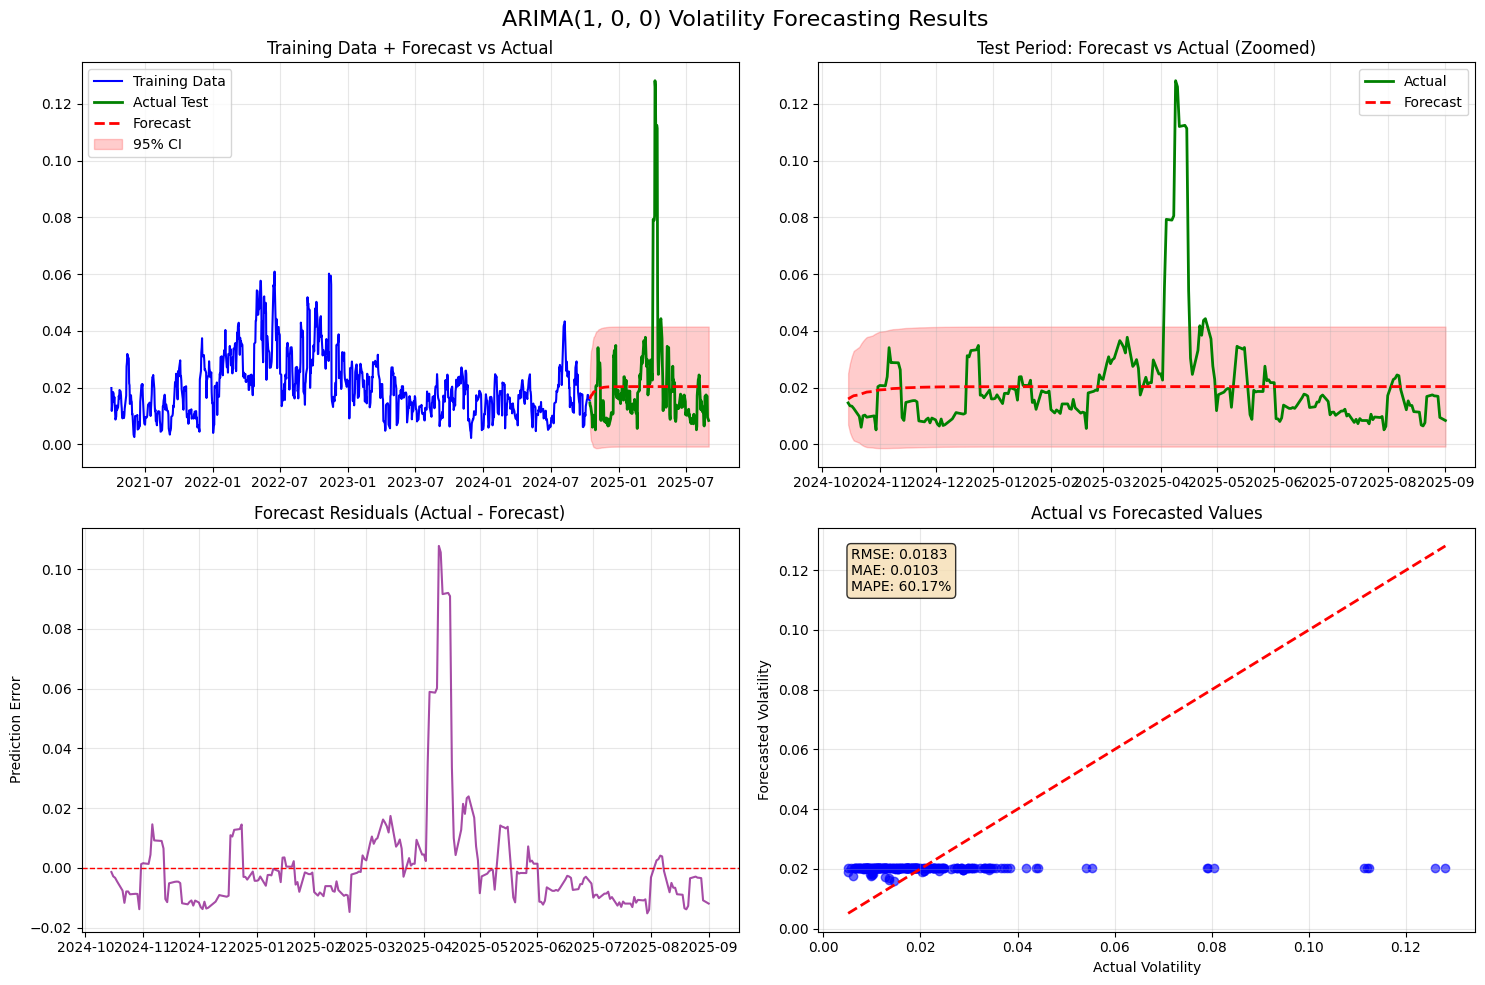

In [5]:
def plot_arima_results(train_data, test_data, results_df, metrics, model_order):
    """
    Create comprehensive plots comparing forecasts vs actuals
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'ARIMA{model_order} Volatility Forecasting Results', fontsize=16)
    
    # Plot 1: Full timeline with forecast
    axes[0,0].plot(train_data.index, train_data.values, label='Training Data', color='blue')
    axes[0,0].plot(test_data.index, test_data.values, label='Actual Test', color='green', linewidth=2)
    axes[0,0].plot(results_df.index, results_df['Forecast'], label='Forecast', color='red', linestyle='--', linewidth=2)
    axes[0,0].fill_between(results_df.index, results_df['Lower_CI'], results_df['Upper_CI'], 
                          color='red', alpha=0.2, label='95% CI')
    axes[0,0].set_title('Training Data + Forecast vs Actual')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Zoomed test period
    axes[0,1].plot(test_data.index, test_data.values, label='Actual', color='green', linewidth=2)
    axes[0,1].plot(results_df.index, results_df['Forecast'], label='Forecast', color='red', linestyle='--', linewidth=2)
    axes[0,1].fill_between(results_df.index, results_df['Lower_CI'], results_df['Upper_CI'], 
                          color='red', alpha=0.2)
    axes[0,1].set_title('Test Period: Forecast vs Actual (Zoomed)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Residuals
    residuals = results_df['Actual'] - results_df['Forecast']
    axes[1,0].plot(results_df.index, residuals, color='purple', alpha=0.7)
    axes[1,0].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[1,0].set_title('Forecast Residuals (Actual - Forecast)')
    axes[1,0].set_ylabel('Prediction Error')
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Actual vs Forecast
    axes[1,1].scatter(results_df['Actual'], results_df['Forecast'], alpha=0.6, color='blue')
    min_val = min(results_df['Actual'].min(), results_df['Forecast'].min())
    max_val = max(results_df['Actual'].max(), results_df['Forecast'].max())
    axes[1,1].plot([min_val, max_val], [min_val, max_val], 'red', linestyle='--', linewidth=2)
    axes[1,1].set_xlabel('Actual Volatility')
    axes[1,1].set_ylabel('Forecasted Volatility')
    axes[1,1].set_title('Actual vs Forecasted Values')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add metrics as text
    metrics_text = f"RMSE: {metrics['RMSE']:.4f}\nMAE: {metrics['MAE']:.4f}"
    if not np.isnan(metrics['MAPE']):
        metrics_text += f"\nMAPE: {metrics['MAPE']:.2f}%"
    axes[1,1].text(0.05, 0.95, metrics_text, transform=axes[1,1].transAxes,
                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return residuals

# Plot the results
residuals = plot_arima_results(train_data, test_data, results, metrics, (1,0,0))

In [6]:
# run cross-validation
def time_series_cross_validation_arima(series, n_splits=5, order=(1,0,0), min_train_size=None):
    """
    Perform time series cross-validation for ARIMA model.
    
    Parameters:
    series (pd.Series): Time series data
    n_splits (int): Number of CV folds
    order (tuple): ARIMA order (p,d,q)
    min_train_size (int): Minimum training size for first fold (optional)
    
    Returns:
    dict: Cross-validation results with metrics and predictions
    """
    from sklearn.model_selection import TimeSeriesSplit
    import warnings
    warnings.filterwarnings('ignore')
    
    # Set minimum training size to 30% for training
    if min_train_size is None:
        min_train_size = int(len(series) * 0.3)
    
    # Create time series split
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Store results
    cv_results = {
        'fold_metrics': [],
        'fold_predictions': [],
        'fold_models': [],
        'overall_metrics': {}
    }
    
    print(f"=== ARIMA TIME SERIES CROSS-VALIDATION ===")
    print(f"Total samples: {len(series)}")
    print(f"Number of folds: {n_splits}")
    print(f"ARIMA order: {order}")
    print(f"Minimum training size: {min_train_size}")
    print("=" * 50)
    
    fold_num = 1
    
    for train_idx, test_idx in tscv.split(series):
        # Ensure minimum training size
        if len(train_idx) < min_train_size:
            print(f"Skipping fold {fold_num}: insufficient training data ({len(train_idx)} < {min_train_size})")
            fold_num += 1
            continue
            
        print(f"\n--- FOLD {fold_num} ---")
        print(f"Train: {series.index[train_idx[0]]} to {series.index[train_idx[-1]]} ({len(train_idx)} samples)")
        print(f"Test:  {series.index[test_idx[0]]} to {series.index[test_idx[-1]]} ({len(test_idx)} samples)")
        
        # Split data
        train_data = series.iloc[train_idx]
        test_data = series.iloc[test_idx]
        
        try:
            # Fit ARIMA model
            model = ARIMA(train_data, order=order)
            fitted_model = model.fit()
            
            # Make predictions
            forecast_result = fitted_model.get_forecast(steps=len(test_data))
            test_pred = forecast_result.predicted_mean
            confidence_int = forecast_result.conf_int()
            
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(test_data, test_pred))
            mae = mean_absolute_error(test_data, test_pred)
            
            # Handle MAPE calculation (avoid division by zero)
            mape_values = np.abs((test_data - test_pred) / test_data)
            mape_values = mape_values[~np.isinf(mape_values)]  # Remove infinite values
            mape = np.mean(mape_values) * 100 if len(mape_values) > 0 else np.nan
            
            # Store fold results
            fold_metrics = {
                'fold': fold_num,
                'train_size': len(train_idx),
                'test_size': len(test_idx),
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'AIC': fitted_model.aic,
                'BIC': fitted_model.bic
            }
            
            fold_predictions = pd.DataFrame({
                'Actual': test_data.values,
                'Forecast': test_pred.values,
                'Lower_CI': confidence_int.iloc[:, 0].values,
                'Upper_CI': confidence_int.iloc[:, 1].values,
                'Fold': fold_num
            }, index=test_data.index)
            
            cv_results['fold_metrics'].append(fold_metrics)
            cv_results['fold_predictions'].append(fold_predictions)
            cv_results['fold_models'].append(fitted_model)
            
            print(f"RMSE: {rmse:.6f}")
            print(f"MAE: {mae:.6f}")
            print(f"MAPE: {mape:.2f}%")
            print(f"AIC: {fitted_model.aic:.4f}")
            
        except Exception as e:
            print(f"Fold {fold_num} failed: {e}")
            fold_num += 1
            continue
        
        fold_num += 1
    
    # Calculate overall metrics
    if cv_results['fold_metrics']:
        metrics_df = pd.DataFrame(cv_results['fold_metrics'])
        
        cv_results['overall_metrics'] = {
            'mean_RMSE': metrics_df['RMSE'].mean(),
            'std_RMSE': metrics_df['RMSE'].std(),
            'mean_MAE': metrics_df['MAE'].mean(),
            'std_MAE': metrics_df['MAE'].std(),
            'mean_MAPE': metrics_df['MAPE'].mean(),
            'std_MAPE': metrics_df['MAPE'].std(),
            'mean_AIC': metrics_df['AIC'].mean(),
            'std_AIC': metrics_df['AIC'].std(),
            'mean_BIC': metrics_df['BIC'].mean(),
            'std_BIC': metrics_df['BIC'].std()
        }
        
        print(f"\n=== OVERALL CROSS-VALIDATION RESULTS ===")
        print(f"Mean RMSE: {cv_results['overall_metrics']['mean_RMSE']:.6f} ± {cv_results['overall_metrics']['std_RMSE']:.6f}")
        print(f"Mean MAE:  {cv_results['overall_metrics']['mean_MAE']:.6f} ± {cv_results['overall_metrics']['std_MAE']:.6f}")
        # print(f"Mean MAPE: {cv_results['overall_metrics']['mean_MAPE']:.2f}% ± {cv_results['overall_metrics']['std_MAPE']:.2f}%")
        print(f"Mean AIC:  {cv_results['overall_metrics']['mean_AIC']:.4f} ± {cv_results['overall_metrics']['std_AIC']:.4f}")
        print(f"Mean BIC:  {cv_results['overall_metrics']['mean_BIC']:.4f} ± {cv_results['overall_metrics']['std_BIC']:.4f}")
    
    return cv_results


In [7]:
# Run ARIMA cross-validation
print("Running Time Series Cross-Validation for ARIMA Model...")
arima_cv_results = time_series_cross_validation_arima(
    series=series,
    n_splits=5,
    order=(1,0,0),
    min_train_size=200
)

Running Time Series Cross-Validation for ARIMA Model...
=== ARIMA TIME SERIES CROSS-VALIDATION ===
Total samples: 1168
Number of folds: 5
ARIMA order: (1, 0, 0)
Minimum training size: 200
Skipping fold 1: insufficient training data (198 < 200)

--- FOLD 2 ---
Train: 2021-04-01 00:00:00 to 2022-09-26 00:00:00 (392 samples)
Test:  2022-09-27 00:00:00 to 2023-06-20 00:00:00 (194 samples)
RMSE: 0.010167
MAE: 0.007602
MAPE: nan%
AIC: -3017.0524

--- FOLD 3 ---
Train: 2021-04-01 00:00:00 to 2023-06-20 00:00:00 (586 samples)
Test:  2023-06-21 00:00:00 to 2024-03-14 00:00:00 (194 samples)
RMSE: 0.009484
MAE: 0.008119
MAPE: nan%
AIC: -4487.0539

--- FOLD 4 ---
Train: 2021-04-01 00:00:00 to 2024-03-14 00:00:00 (780 samples)
Test:  2024-03-15 00:00:00 to 2024-12-06 00:00:00 (194 samples)
RMSE: 0.009082
MAE: 0.007709
MAPE: nan%
AIC: -6093.1875

--- FOLD 5 ---
Train: 2021-04-01 00:00:00 to 2024-12-06 00:00:00 (974 samples)
Test:  2024-12-09 00:00:00 to 2025-09-01 00:00:00 (194 samples)
RMSE: 0.0196

In [8]:
# Calculate R² (Coefficient of Determination) for the ARIMA model
from sklearn.metrics import r2_score

def calculate_arima_r2_metrics(model, train_data, test_data, results_df=None):
    """
    Calculate R² for both training and test data for ARIMA model.
    
    Parameters:
    model: Fitted ARIMA model
    train_data: Training data
    test_data: Test data
    results_df: DataFrame with forecasts (optional)
    
    Returns:
    dict: R² metrics for training and test data
    """
    
    # Calculate R² for training data using fitted values
    train_fitted = model.fittedvalues
    train_r2 = r2_score(train_data, train_fitted)
    
    # Calculate R² for test data
    if results_df is not None:
        # Use forecasts from the provided DataFrame
        test_pred = results_df['Forecast']
        test_r2 = r2_score(test_data, test_pred)
    else:
        # Generate forecasts if not provided
        forecast_result = model.get_forecast(steps=len(test_data))
        test_pred = forecast_result.predicted_mean
        test_r2 = r2_score(test_data, test_pred)
    
    # Calculate additional metrics manually
    train_ss_res = np.sum((train_data - train_fitted) ** 2)
    train_ss_tot = np.sum((train_data - np.mean(train_data)) ** 2)
    
    test_ss_res = np.sum((test_data - test_pred) ** 2)
    test_ss_tot = np.sum((test_data - np.mean(test_data)) ** 2)
    
    r2_metrics = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_ss_res': train_ss_res,
        'train_ss_tot': train_ss_tot,
        'test_ss_res': test_ss_res,
        'test_ss_tot': test_ss_tot
    }
    
    return r2_metrics

# Calculate R² for the main ARIMA model (single split)
if 'model' in locals() and model is not None:
    r2_metrics_arima = calculate_arima_r2_metrics(
        model=model,
        train_data=train_data,
        test_data=test_data,
        results_df=results
    )
    
    print("=== ARIMA R² (COEFFICIENT OF DETERMINATION) ANALYSIS ===")
    print(f"Training R²: {r2_metrics_arima['train_r2']:.6f}")
    print(f"Test R²:     {r2_metrics_arima['test_r2']:.6f}")

else:
    print("ARIMA model not available. Please run the model fitting first.")


=== ARIMA R² (COEFFICIENT OF DETERMINATION) ANALYSIS ===
Training R²: 0.815627
Test R²:     0.005638
